In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat, loadmat

In [2]:
%matplotlib inline

In [3]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [4]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]

    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs

    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]

    else:
        raise IOError('please set to_what to either mni or xyz')

    return x,y,z

In [72]:
def structural_connectivity_analysis(input_img, df, col, ant_cut, post_cut, vdim, 
                                         mask_thr=0.2, outdir = None, outname='strucx'):
        
        print('initializing')
        i4d = input_img.get_data()
        avg_image = i4d.mean(3)
        mask = np.zeros_like(avg_image)
        mask[avg_image>mask_thr] = 1
        mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,input_img.affine))
        i2d = mskr.fit_transform(input_img)
        
        print('creating anterior connectivity map')
        antdf = df[df[col]>=ant_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
        ant_mtx = get_structural_connectivity(antdf, i4d, i2d, vdim)
        ant_image = mskr.inverse_transform(ant_mtx).get_data().mean(3)
        
        print('creating posterior connectivity map')
        postdf = df[df[col]<=post_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
        post_mtx = get_structural_connectivity(postdf, i4d, i2d, vdim)
        post_image = mskr.inverse_transform(post_mtx).get_data().mean(3)
        
        diff_image = ni.Nifti1Image((ant_image - post_image), input_img.affine)
        ant_image = ni.Nifti1Image(ant_image,input_img.affine)
        post_image = ni.Nifti1Image(post_image,input_img.affine)
        output = {'anterior': ant_image,
                 'posterior': post_image,
                 'difference': diff_image}
    
        if outdir:
            for lab, image in output.items():
                image.to_filename(os.path.join(wdir,'%s_%s'%(outname,lab)))
        
        return output
            
def get_structural_connectivity(cdf, i4d, i2d, vdim, embedded=True, convert=True):

    rmat = np.zeros((len(cdf),i2d.shape[1]))
    for i,c in enumerate(cdf.index):
        if convert:
            coord = [int(round(x)) for x in convert_coords(cdf.loc[c].values, 'xyz', vdim)]
        else:
            coord = cdf.loc[c]
        print('computing %s of %s connectivity maps'%(i+1,len(cdf)))
        cvec = i4d[coord[0],coord[1],coord[2],:]
        rs = [stats.pearsonr(cvec,i2d[:,x])[0] for x in range(i2d.shape[1])]
        rmat[i,:] = rs
    if embedded:
        rvec = rmat.mean(0)
        r_mtx = np.repeat(np.array(rvec)[:, np.newaxis], i2d.shape[0], axis=1).T

        return r_mtx
    else:
        return rmat

### Load GMV data

In [27]:
from nilearn import datasets, plotting, image, input_data
data = datasets.fetch_oasis_vbm()
demos = pandas.DataFrame(data.ext_vars)
scans = []
for sub in [str(x)[2:-5] for x in demos[demos.age < 40]['id'].values]:
    for scan in data['gray_matter_maps']:
        if sub in scan:
            scans.append(scan)

In [66]:
gmvs = image.load_img(scans)
gmvs.shape

(91, 109, 91, 153)

### Select coordinates evenly spaced along the A-P axis, plus the true coordinates

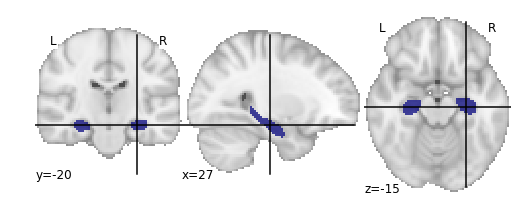

In [28]:
atl = ni.load('/usr/share/fsl/5.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr50-2mm.nii.gz')
atl_dat = atl.get_data()
hipp = np.zeros_like(atl_dat)
hipp[atl_dat==9] = 1
hipp[atl_dat==19] = 1
hipp_img = ni.Nifti1Image(hipp, atl.affine)
plotting.plot_roi(hipp_img)

In [29]:
hipp_coords = pandas.DataFrame(np.array(np.where(hipp==1))).T
hipp_coords.columns = ['x','y','z']
#hipp_coords.y.value_counts()

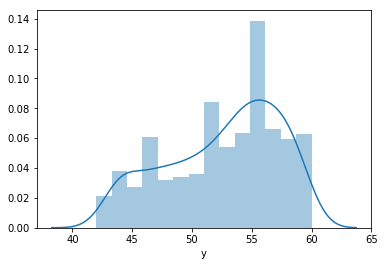

In [11]:
sns.distplot(hipp_coords.y)

In [12]:
len(hipp_coords.y.value_counts())

19

In [13]:
len(hipp_coords) * 0.20

211.0

So the plan will be to randomly extract 20% of the hippocampus coordinates. I will do so by taking a random 20% of all coordinates at each y-index. This way, we will maintain the volume distribution across the axis, but still adequately sample each spot along the axis

In [30]:
selected = []
for yc in hipp_coords.y.unique():
    ydf = hipp_coords[hipp_coords.y==yc]
    ylen = int(round(len(ydf)*0.20))
    sel_ind = np.random.choice(ydf.index, size=ylen, replace=False)
    selected.append(ydf.loc[sel_ind])

In [31]:
to_xtract = pandas.concat(selected)
to_xtract.shape

(211, 3)

In [32]:
coords = df[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]

In [33]:
coords.head()

,mni_nlin_x,mni_nlin_y,mni_nlin_z
0,21.876385,-42.363260,4.710402
1,23.899152,-40.879051,8.176524
2,22.703225,-40.994060,8.301460
3,22.928779,-41.054804,7.141831
4,24.115367,-40.962119,7.018704


In [48]:
ncoords = pandas.DataFrame([convert_coords(coords.loc[x].values, 
                                           'xyz', 
                                           vs=2
                                          ) for x in coords.index]
                          )
for i,row in ncoords.iterrows():
    ncoords.loc[i,:] = [int(round(x)) for x in ncoords.loc[i].values]
ncoords = ncoords.astype(int)
ncoords.head()

,0,1,2
0,34,42,38
1,33,43,40
2,34,43,40
3,34,42,40
4,33,43,40


In [49]:
# first remove duplicates from this list
safe = []
for i in ncoords.index:
    jnk = ncoords.loc[i].tolist()
    if jnk not in safe:
        safe.append(jnk)
    else:
        ncoords.drop(i,inplace=True)

In [53]:
i = 5
jnk = ncoords.loc[i].tolist()
jnk

[60, 54, 27]

In [55]:
len([jnk == hipp_coords.loc[x].tolist() for x in hipp_coords.index])

1055

In [57]:
dups = []
for i in ncoords.index:
    jnk = ncoords.loc[i].tolist()
    assessment = any([jnk == hipp_coords.loc[x].tolist() for x in to_xtract.index])
    if assessment:
        dups.append(i)

In [58]:
#dups = [9, 54, 55, 78, 79, 87, 152]
dups

[9, 18, 24, 36, 39, 55, 57, 60, 65, 75, 101, 133, 146, 152, 159, 165, 167]

In [59]:
ncoords.drop(dups,inplace=True)

In [60]:
ncoords.columns = ['x','y','z']

In [61]:
cdf = pandas.concat([to_xtract, ncoords], axis=0, ignore_index=True)
cdf.shape

(332, 3)

In [62]:
samples = np.zeros_like(hipp)
for i,row in cdf.iterrows():
    samples[tuple(cdf.loc[i].tolist())] = 1

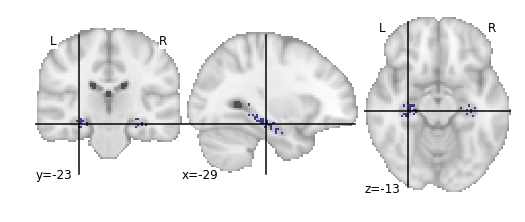

In [63]:
plotting.plot_roi(ni.Nifti1Image(samples, atl.affine))

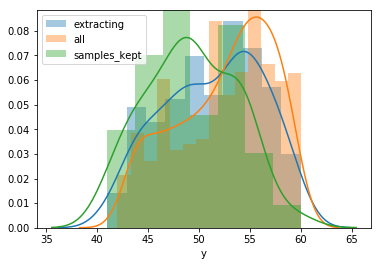

In [64]:
sns.distplot(cdf.y, label='extracting')
sns.distplot(hipp_coords.y, label='all')
sns.distplot(ncoords.y, label='samples_kept')
plt.legend()

### Extract data from the coordinates!

In [76]:
gmvs.shape

(91, 109, 91, 153)

In [73]:
# ALL COORDINATES FOR DIFFUSION EMBEDDING
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(gmvs)
all_mtx = get_structural_connectivity(cdf, i4d, i2d, vdim=2, embedded=False, convert=False)

computing 1 of 332 connectivity maps
computing 2 of 332 connectivity maps
computing 3 of 332 connectivity maps
computing 4 of 332 connectivity maps
computing 5 of 332 connectivity maps
computing 6 of 332 connectivity maps
computing 7 of 332 connectivity maps
computing 8 of 332 connectivity maps
computing 9 of 332 connectivity maps
computing 10 of 332 connectivity maps
computing 11 of 332 connectivity maps
computing 12 of 332 connectivity maps
computing 13 of 332 connectivity maps
computing 14 of 332 connectivity maps
computing 15 of 332 connectivity maps
computing 16 of 332 connectivity maps
computing 17 of 332 connectivity maps
computing 18 of 332 connectivity maps
computing 19 of 332 connectivity maps
computing 20 of 332 connectivity maps
computing 21 of 332 connectivity maps
computing 22 of 332 connectivity maps
computing 23 of 332 connectivity maps
computing 24 of 332 connectivity maps
computing 25 of 332 connectivity maps
computing 26 of 332 connectivity maps
computing 27 of 332 c

computing 214 of 332 connectivity maps
computing 215 of 332 connectivity maps
computing 216 of 332 connectivity maps
computing 217 of 332 connectivity maps
computing 218 of 332 connectivity maps
computing 219 of 332 connectivity maps
computing 220 of 332 connectivity maps
computing 221 of 332 connectivity maps
computing 222 of 332 connectivity maps
computing 223 of 332 connectivity maps
computing 224 of 332 connectivity maps
computing 225 of 332 connectivity maps
computing 226 of 332 connectivity maps
computing 227 of 332 connectivity maps
computing 228 of 332 connectivity maps
computing 229 of 332 connectivity maps
computing 230 of 332 connectivity maps
computing 231 of 332 connectivity maps
computing 232 of 332 connectivity maps
computing 233 of 332 connectivity maps
computing 234 of 332 connectivity maps
computing 235 of 332 connectivity maps
computing 236 of 332 connectivity maps
computing 237 of 332 connectivity maps
computing 238 of 332 connectivity maps
computing 239 of 332 conn

In [74]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_PLUS_coords_matrix', 
                    all_mtx)

In [78]:
all_mtx.shape

(332, 148661)

In [75]:
jnk = {'all_mtx': all_mtx}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_PLUS_coords_matrix',jnk)

In [101]:
all_mtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_PLUS_coords_matrix.npz'
                 )['arr_0']

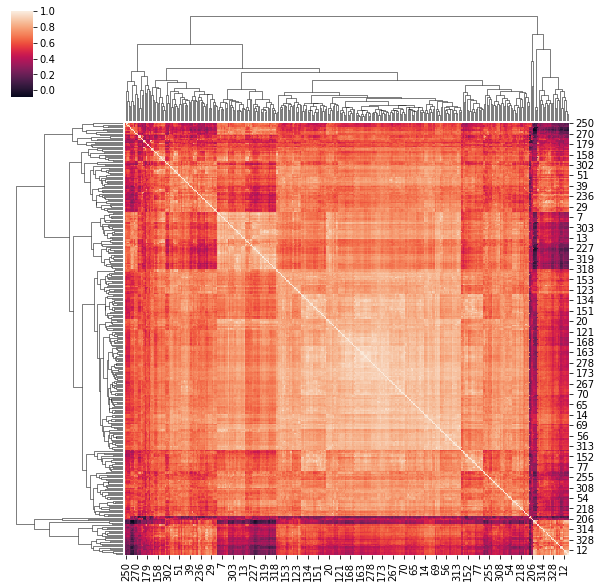

In [79]:
sns.clustermap(np.corrcoef(all_mtx))

In [81]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_ALLPLUS_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_ALLPLUS_res.mat')

In [112]:
del(all_mtx)

In [83]:
lambdas = res['res'][0][0][1]
list(zip(range(lambdas.shape[-1]),(lambdas / np.sum(lambdas))[0,:]))

[(0, 0.21165033669609848),
 (1, 0.14545446790288497),
 (2, 0.13149095709587158),
 (3, 0.095561649943409446),
 (4, 0.058804765731855294),
 (5, 0.052691948718479903),
 (6, 0.049687856287707999),
 (7, 0.041709926903286003),
 (8, 0.035941819318410097),
 (9, 0.030440787728105941),
 (10, 0.027527017372516768),
 (11, 0.025439710628973933),
 (12, 0.021591470907290959),
 (13, 0.019910809237519703),
 (14, 0.019307444083338877),
 (15, 0.016565062811259527),
 (16, 0.016223968632990287)]

### Map sample coordinates to samples passed to DME

In [45]:
i = 0
jnk = convert_coords(coords.loc[i].values, 'xyz', vs=2)
jnk = [int(round(x)) for x in jnk]
jnk    

[34, 42, 38]

In [46]:
cdf.loc[0].tolist() == jnk

False

In [86]:
match_ind = []
for i,row in coords.iterrows():
    jnk = convert_coords(coords.loc[i].values, 'xyz', vs=2)
    jnk = [int(round(x)) for x in jnk]
    ind = [1 if cdf.loc[x].tolist() == jnk else 0 for x in cdf.index]
    if sum(ind) == 0:
        print('NO MATCH FOUND FOR',i)
    elif sum(ind)>1:
        print('MULTIPLE MATCHES FOUND FOR',i)
    else:
        mind = np.argmax(ind)
        match_ind.append(cdf.index[mind])

In [87]:
len(match_ind)

170

In [89]:
svecs = res['res'][0][0][4][match_ind]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,i]))

0 (0.045458833503245637, 0.55610137350231281)
1 (-0.63977766096872513, 5.9274599154381154e-21)
2 (-0.018616590411076977, 0.80958559574232258)
3 (-0.12229267722253016, 0.11212671194045752)
4 (-0.26807511923544514, 0.00040870182890502782)
5 (0.29206727027043206, 0.00011127007230353052)
6 (0.14214270480071453, 0.064451963090192077)
7 (-0.1345212725805916, 0.080297814157826039)
8 (-0.083077823731682418, 0.28144737672759601)
9 (0.11553967456999661, 0.13351913280183311)
10 (0.29797254404062729, 7.9318704553910143e-05)
11 (-0.22153552991243713, 0.003692257107335852)
12 (-0.099420903304983391, 0.19707690741907782)
13 (-0.23316327489921018, 0.0022138401442056157)
14 (0.024469445228950972, 0.75144386037960142)
15 (-0.047035676035906894, 0.54246958302337167)
16 (-0.075319765206674036, 0.3289695495691789)
17 (-0.069905523955517385, 0.36502021699185427)


In [96]:
df.columns

Index(['Unnamed: 0.1', 'donor', 'sample', 'structure_id', 'slab_num',
       'well_id', 'slab_type', 'structure_acronym', 'structure_name',
       'polygon_id', 'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x',
       'mni_y', 'mni_z', 'gabe_label', 'mni_nlin_x', 'mni_nlin_y',
       'mni_nlin_z', 'position_along_hipp_AP_axis', 'bilateral_structure_name',
       'hemisphere', 'ntn1', 'fstl4', 'rsph9', 'nr2f2', 'fam43b', 'All 58k',
       'Set 1', 'Set 2', 'Set 1,2', 'Set 3', 'Set 1,2,3'],
      dtype='object')

In [94]:
df = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_ALLVAR_hippocampus_sample_info.csv',
                    index_col=0)

In [97]:
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df['All 58k'], svecs[:,i]))

0 (0.02159274573412728, 0.77986850145685704)
1 (-0.60444473894859929, 2.6039554138470094e-18)
2 (0.027970770417656582, 0.71729643586209213)
3 (-0.10816601032969024, 0.1603099471935911)
4 (-0.26533998083379257, 0.00047055384471895762)
5 (0.25376418265437567, 0.00084050782706259299)
6 (0.072696291540249425, 0.34614259466769459)
7 (-0.15295251754469619, 0.04645057396559181)
8 (-0.099186535795346656, 0.19814011846845456)
9 (0.11145543591334156, 0.14789921813578127)
10 (0.28468956306441617, 0.0001681058667128577)
11 (-0.28990948658040766, 0.00012568972599520469)
12 (-0.091632066164033785, 0.23466669532400702)
13 (-0.22634504768793182, 0.002997223916559709)
14 (-0.011537067035135488, 0.88130106189816082)
15 (-0.052897075589047986, 0.49329040131134494)
16 (-0.044887419675884964, 0.56108180068667024)
17 (-0.048372043843867715, 0.53104742369529112)


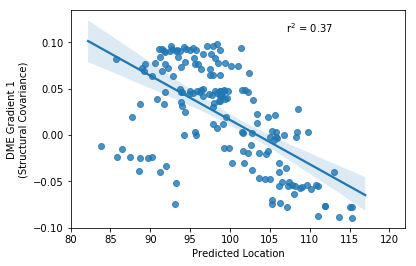

In [98]:
plt.close()
sns.regplot(df['All 58k'], svecs[:,1])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 1\n(Structural Covariance)')
r,p = stats.pearsonr(df['All 58k'], svecs[:,1])
plt.text(107,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_predicted.pdf',
#           bbox_inches='tight')
plt.show()

In [99]:
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine)).fit()

In [104]:
vecs = vecs = res['res'][0][0][4]
vec1_cx = np.dot(all_mtx.T, vecs[:,1])
vec1_dat = mskr.inverse_transform(vec1_cx)

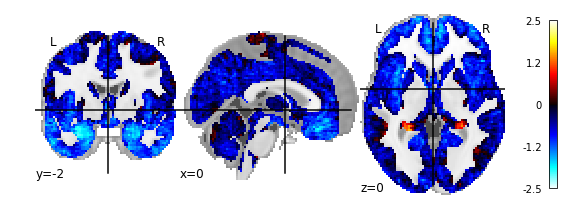

In [107]:
plt.close()
plotting.plot_stat_map(vec1_dat)
plt.show()
#vec1_dat.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_first_vector')

###  TRY AGAIN AFTER SMOOTHING

In [111]:
sgmvs = image.smooth_img(gmvs, 6)

In [113]:
# ALL COORDINATES FOR DIFFUSION EMBEDDING
i4d = sgmvs.get_data()
avg_image = i4d.mean(3)
#mask = np.zeros_like(avg_image)
#mask_thr = 0.2
#mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(sgmvs)
all_mtx = get_structural_connectivity(cdf, i4d, i2d, vdim=2, embedded=False, convert=False)

computing 1 of 332 connectivity maps
computing 2 of 332 connectivity maps
computing 3 of 332 connectivity maps
computing 4 of 332 connectivity maps
computing 5 of 332 connectivity maps
computing 6 of 332 connectivity maps
computing 7 of 332 connectivity maps
computing 8 of 332 connectivity maps
computing 9 of 332 connectivity maps
computing 10 of 332 connectivity maps
computing 11 of 332 connectivity maps
computing 12 of 332 connectivity maps
computing 13 of 332 connectivity maps
computing 14 of 332 connectivity maps
computing 15 of 332 connectivity maps
computing 16 of 332 connectivity maps
computing 17 of 332 connectivity maps
computing 18 of 332 connectivity maps
computing 19 of 332 connectivity maps
computing 20 of 332 connectivity maps
computing 21 of 332 connectivity maps
computing 22 of 332 connectivity maps
computing 23 of 332 connectivity maps
computing 24 of 332 connectivity maps
computing 25 of 332 connectivity maps
computing 26 of 332 connectivity maps
computing 27 of 332 c

computing 214 of 332 connectivity maps
computing 215 of 332 connectivity maps
computing 216 of 332 connectivity maps
computing 217 of 332 connectivity maps
computing 218 of 332 connectivity maps
computing 219 of 332 connectivity maps
computing 220 of 332 connectivity maps
computing 221 of 332 connectivity maps
computing 222 of 332 connectivity maps
computing 223 of 332 connectivity maps
computing 224 of 332 connectivity maps
computing 225 of 332 connectivity maps
computing 226 of 332 connectivity maps
computing 227 of 332 connectivity maps
computing 228 of 332 connectivity maps
computing 229 of 332 connectivity maps
computing 230 of 332 connectivity maps
computing 231 of 332 connectivity maps
computing 232 of 332 connectivity maps
computing 233 of 332 connectivity maps
computing 234 of 332 connectivity maps
computing 235 of 332 connectivity maps
computing 236 of 332 connectivity maps
computing 237 of 332 connectivity maps
computing 238 of 332 connectivity maps
computing 239 of 332 conn

In [114]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_SMOOTH_ALL_PLUS_coords_matrix', 
                    all_mtx)
jnk = {'all_mtx': all_mtx}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_SMOOTH_ALL_PLUS_coords_matrix',jnk)

In [115]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_SMOOTH_ALLPLUS_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_SMOOTH_ALLPLUS_res.mat')

In [116]:
svecs = res['res'][0][0][4][match_ind]
for i in range(svecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,i]))

0 (0.045458833503245637, 0.55610137350231281)
1 (-0.63977766096872513, 5.9274599154381154e-21)
2 (-0.018616590411076977, 0.80958559574232258)
3 (-0.12229267722253016, 0.11212671194045752)
4 (-0.26807511923544514, 0.00040870182890502782)
5 (0.29206727027043206, 0.00011127007230353052)
6 (0.14214270480071453, 0.064451963090192077)
7 (-0.1345212725805916, 0.080297814157826039)
8 (-0.083077823731682418, 0.28144737672759601)
9 (0.11553967456999661, 0.13351913280183311)
10 (0.29797254404062729, 7.9318704553910143e-05)
11 (-0.22153552991243713, 0.003692257107335852)
12 (-0.099420903304983391, 0.19707690741907782)
13 (-0.23316327489921018, 0.0022138401442056157)
14 (0.024469445228950972, 0.75144386037960142)
15 (-0.047035676035906894, 0.54246958302337167)
16 (-0.075319765206674036, 0.3289695495691789)
17 (-0.069905523955517385, 0.36502021699185427)
